# <h1 align="center">Trabajo Practico 1: UdeSA Panoramica</h1>

In [4]:
import matplotlib.pyplot as plt
import cv2
from i308_utils import imshow, show_images

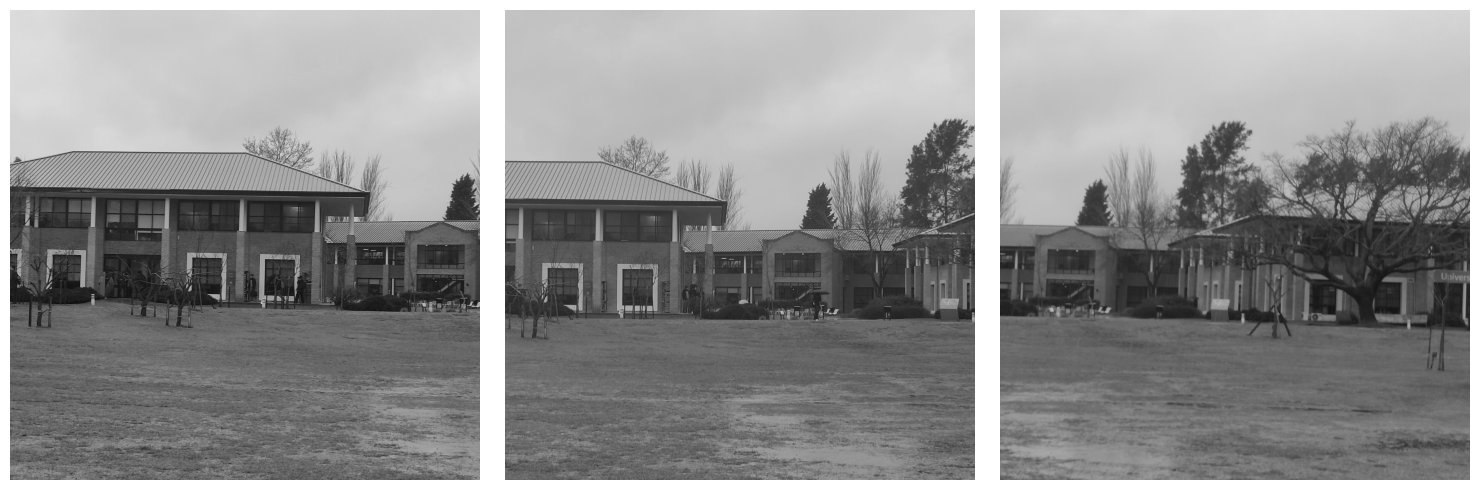

In [7]:
images = [cv2.cvtColor(plt.imread(f'img/udesa_{i}.jpg'), cv2.COLOR_RGB2GRAY) for i in range(0,3)]
show_images(images, figsize=(15,5))

## Deteccion y Descripcion de Caracteristicas Visuales

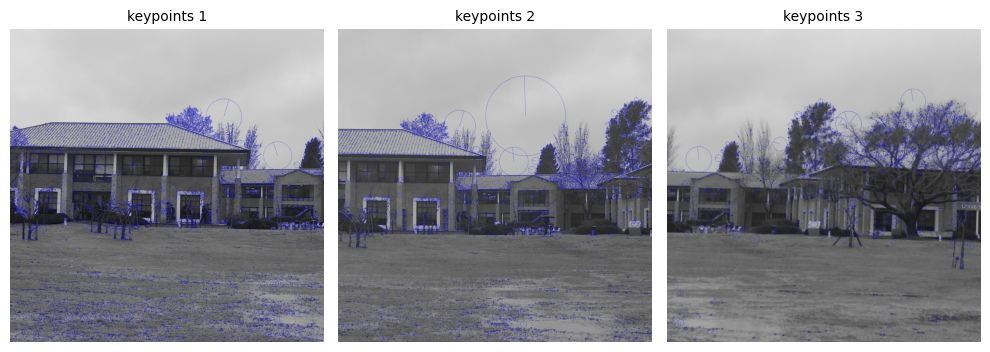

In [ ]:
sift_algo = cv2.SIFT_create()
images_keypoints = []
images_descriptors = []

for i in range(len(images)):
    kp, des = sift_algo.detectAndCompute(images[i], None)
    images_keypoints.append(kp)
    images_descriptors.append(des)

images_with_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_kp = cv2.drawKeypoints(
        img_bgr,
        images_keypoints[i],
        0, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_kp.append(img_with_kp)

show_images(images_with_kp, ["keypoints 1", "keypoints 2", "keypoints 3"])

